# Constructing a BPF function
Here we optimize the coefficients of the cosine approximation to a boxcar function, as a benchmark. (Of course, the correct answer here is the Fourier series of the boxcar)

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [4]:
w = torch.linspace(0.1,2,41) # for plotting
polynomial_target = torch.zeros(len(w))
polynomial_target = torch.zeros(len(w))
polynomial_target[int(0.25*len(w)):int(0.75*len(w))] = 1
def computeCurve(parameters):
    # polynomial_w = sum(c * w**i for i, c in enumerate(parameters))
    # polynomial_w = sum(c * np.cos(i*w) for i, c in enumerate(parameters))
    polynomial_w = sum(c * np.exp(1j*i*w) for i, c in enumerate(parameters))
    return polynomial_w 
def computeError(parameters):
    polynomial_w = computeCurve(parameters)
    # loss = nn.MSELoss()(polynomial_w, polynomial_target)
    loss_real = nn.MSELoss()(torch.real(polynomial_w), torch.real(polynomial_target))
    loss_imag = nn.MSELoss()(torch.imag(polynomial_w), torch.real(polynomial_target))
    loss = loss_real+loss_imag
    return loss


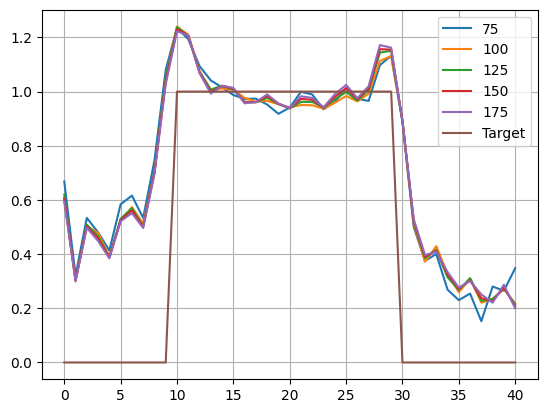

In [15]:
_num_terms = 40 # max number of fourier terms 
parameters = torch.tensor(np.random.rand(_num_terms), requires_grad=True)
fig, axes = plt.subplots(); legend = []
optimizer = torch.optim.Adam([parameters], lr=0.5) # Adaptive algorithm, better
for i in range(200):
    optimizer.zero_grad()
    f = computeError(parameters) 
    f.backward()
    optimizer.step()
    if(i%25==0 and i> 50):
        # print(f'Iteration {i} : (c0,c1,c2) = {[_c.item() for _c in [c0,c1,c2]]}; f = {f.item()}')
        axes.plot(abs(computeCurve(parameters)).detach().numpy())
        legend.append(i)
legend.append('Target')
axes.plot(polynomial_target)
axes.legend(legend)
axes.grid('on')

Works quite nicely!

___

# WIP

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j])

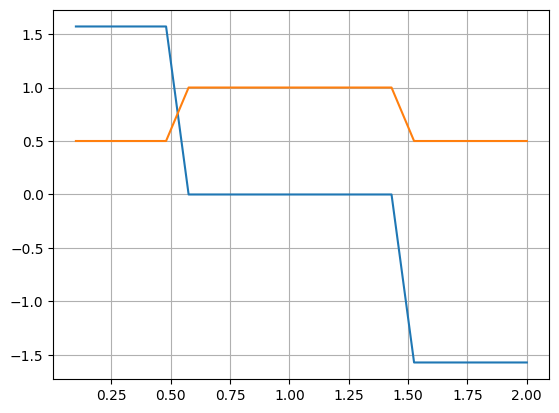

In [48]:
# Define target polynomial
w = torch.linspace(0.1,2,21) # for plotting
# polynomial_target = torch.tensor(np.zeros(len(w),dtype='complex128')) # double precision hits a snag with autodiff
polynomial_target = torch.tensor(np.zeros(len(w),dtype='complex64'))

_w1 = int(0.25*len(w))
_w2 = int(0.75*len(w))
polynomial_target[0:_w1] = 0.5*np.exp(1j*0.5*np.pi)*torch.ones(len(w[0:_w1]))
polynomial_target[_w1:_w2] = torch.ones(len(w[_w1:_w2])) # zero phase, flat passband target
polynomial_target[_w2:] = 0.5*np.exp(-1j*0.5*np.pi)*torch.ones(len(w[_w2:]))
plt.plot(w,np.angle(polynomial_target))
plt.plot(w,np.abs(polynomial_target))
plt.grid()

In [58]:
def computeCurve(parameters):
    # # L1,C1 = parameters.detach().numpy()
    L1,C1 = parameters.clone().detach().numpy()
    # # M = [
    # #     [torch.tensor(1-(w**2)*L1*C1), torch.tensor(w*L1)],
    # #     [torch.tensor(w*C1), torch.ones(len(w))]
    # # ]
    M = [
        [torch.tensor(1-(w**2)*L1*C1), torch.tensor(1j*w*L1)],
        [torch.tensor(1j*w*C1), torch.ones(len(w))]
    ]

    # # # This is basically the magnitude of (A/C)
    # # polynomial_w = torch.tensor(1-(w**2)*L1*C1)/torch.tensor(w*C1)

    polynomial_w = M[0][0]/M[1][0] # for tensors, indexing like M[0,0] wont work
    polynomial_w = sum(c * np.exp(1j*i*w) for i, c in enumerate(parameters))
    return polynomial_w

def computeError(parameters):
    polynomial_w = computeCurve(parameters)
    # print(f'DEBUG: polynomial_w = {polynomial_w}')
    # print(f'DEBUG: polynomial_target = {polynomial_target}')
    loss_real = nn.MSELoss()(torch.real(polynomial_w), torch.real(polynomial_target))
    loss_imag = nn.MSELoss()(torch.imag(polynomial_w), torch.real(polynomial_target))
    loss = loss_real+loss_imag

    # loss = loss_real # testing
    return loss

C:\Users\DELL\AppData\Local\Temp\ipykernel_24332\3309413264.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(1-(w**2)*L1*C1), torch.tensor(1j*w*L1)],
C:\Users\DELL\AppData\Local\Temp\ipykernel_24332\3309413264.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(1j*w*C1), torch.ones(len(w))]


Iteration 10 : (L1,C1) = tensor([0.2369, 0.3731], dtype=torch.float64, requires_grad=True); f = 0.5251912474632263
Iteration 35 : (L1,C1) = tensor([0.2416, 0.4989], dtype=torch.float64, requires_grad=True); f = 0.4982535243034363
Iteration 60 : (L1,C1) = tensor([0.2406, 0.5259], dtype=torch.float64, requires_grad=True); f = 0.4975395202636719
Iteration 85 : (L1,C1) = tensor([0.2566, 0.5233], dtype=torch.float64, requires_grad=True); f = 0.49734872579574585
Iteration 110 : (L1,C1) = tensor([0.2567, 0.5262], dtype=torch.float64, requires_grad=True); f = 0.49733591079711914
Iteration 135 : (L1,C1) = tensor([0.2556, 0.5262], dtype=torch.float64, requires_grad=True); f = 0.4973348379135132
Iteration 160 : (L1,C1) = tensor([0.2555, 0.5263], dtype=torch.float64, requires_grad=True); f = 0.49733489751815796
Iteration 185 : (L1,C1) = tensor([0.2555, 0.5263], dtype=torch.float64, requires_grad=True); f = 0.49733489751815796
Iteration 210 : (L1,C1) = tensor([0.2556, 0.5263], dtype=torch.float64, 

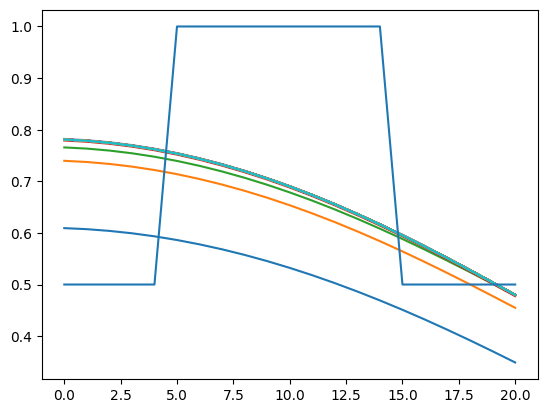

In [59]:

# =======================================================
# parameters = torch.tensor([1.0,2.0,3.0], requires_grad=True)
parameters = torch.tensor(np.random.rand(2), requires_grad=True)

fig, axes = plt.subplots(); legend = []
# optimizer = torch.optim.Adam([parameters], lr=0.5) # Adaptive algorithm, better
optimizer = torch.optim.Adam([parameters], lr=0.05) # Adaptive algorithm, better
for i in range(1000):
    optimizer.zero_grad()
    # f = computeError(c0,c1,c2) 
    f = computeError(parameters) 
    f.backward()
    optimizer.step()
    if(i%25==10):
        print(f'Iteration {i} : (L1,C1) = {parameters}; f = {f.item()}')
        axes.plot(abs(computeCurve(parameters)).detach().numpy())
        legend.append(i)
# legend.append('Target')
axes.plot(abs(polynomial_target))
# axes.legend(legend)
# axes.grid('on')

In [60]:
import torch
import torch.optim as optim

# Create a 2D tensor (matrix)
tensor = torch.randn(3, 4, requires_grad=True)

# Create an optimizer (e.g., Adam)
optimizer = optim.Adam([tensor], lr=0.01)

# Perform optimization steps
for i in range(1000):
    # Compute loss (replace with your actual loss calculation)
    loss = torch.sum(torch.abs(tensor))

    # Update the tensor
    optimizer.zero_grad()  # Clear gradients
    loss.backward()       # Calculate gradients
    optimizer.step()       # Update tensor parameters

In [231]:
tensor

tensor([[ 0.1148,  0.2721, -0.0770,  0.2521],
        [ 0.0303, -0.3785, -0.0987, -0.1926],
        [ 0.4021, -0.1942, -0.0062, -0.2551]], requires_grad=True)